In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.impute import KNNImputer, SimpleImputer
from category_encoders import HashingEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier


%matplotlib inline

In [223]:
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [295]:
# X_train_data = train_data.drop(['Transported'], axis=1)
# Y_train_data = train_data['Transported']

## Checking null value

In [50]:
#Checking null value 
train_data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<AxesSubplot: >

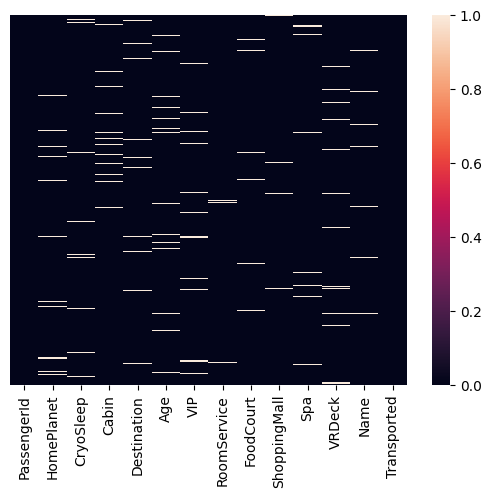

In [5]:
sns.heatmap(train_data.isnull(), yticklabels=False)

### Home Planet

In [50]:
#Checking which Homeplanet is the most tranported 
train_data['HomePlanet'].unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

<AxesSubplot: xlabel='HomePlanet', ylabel='count'>

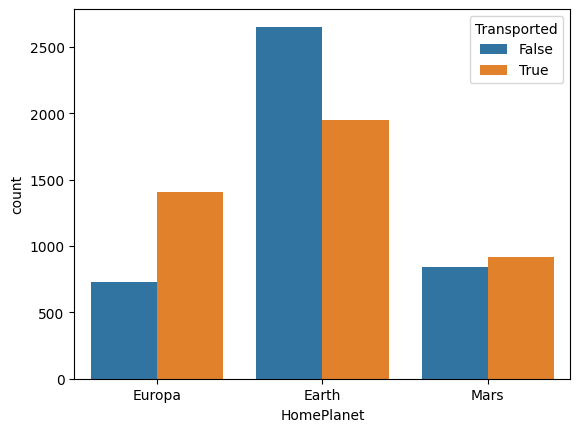

In [12]:
sns.countplot(data=train_data, x="HomePlanet", hue="Transported")

### Destination

In [13]:
train_data['Destination'].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

<AxesSubplot: xlabel='Destination', ylabel='count'>

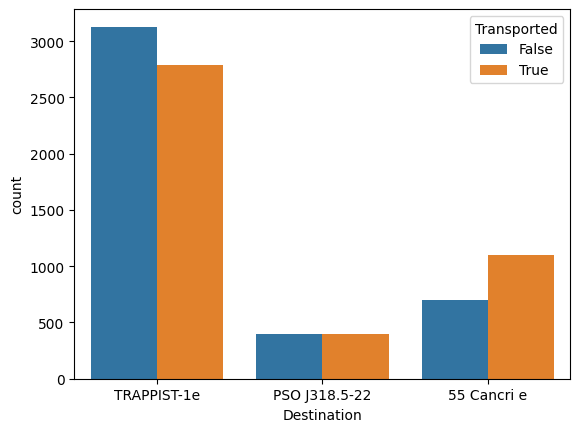

In [14]:
sns.countplot(data=train_data, x="Destination", hue="Transported")

### VIP

<AxesSubplot: xlabel='VIP', ylabel='count'>

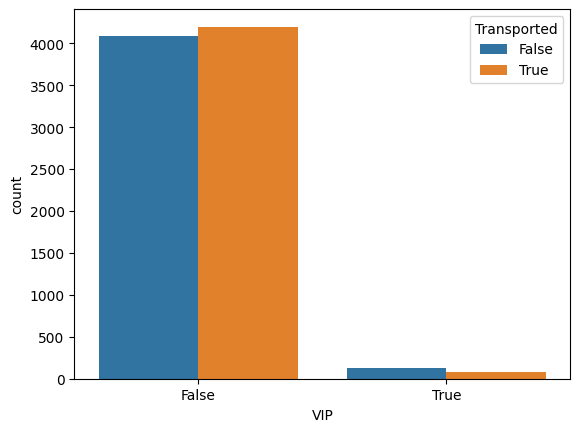

In [15]:
sns.countplot(data=train_data, x="VIP", hue="Transported")

### Age

<AxesSubplot: xlabel='VIP', ylabel='Age'>

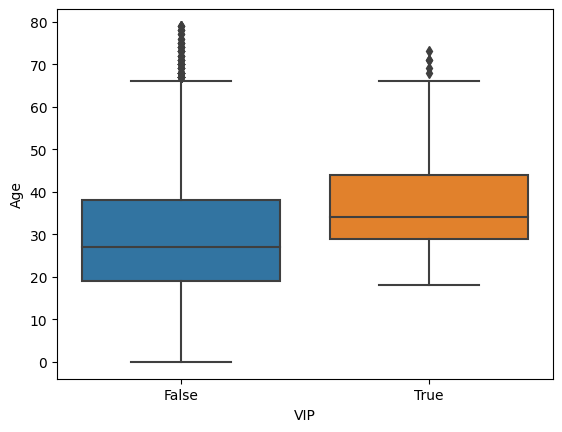

In [16]:
sns.boxplot(x='VIP', y='Age', data=train_data)

In [304]:
print(train_data['Age'][train_data['VIP']==False].median())
print(train_data['Age'][train_data['VIP']==True].median())

27.0
34.0


<AxesSubplot: xlabel='VIP', ylabel='Age'>

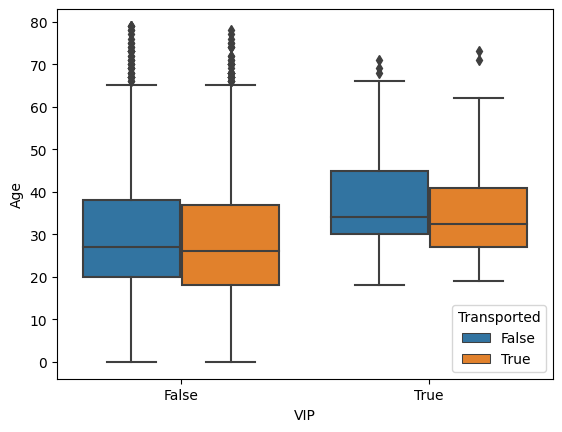

In [17]:
sns.boxplot(x='VIP', y='Age', data=train_data, hue='Transported')

In [306]:
print(train_data['Age'][(train_data['VIP']==False) & (train_data['Transported']==True)].median())
print(train_data['Age'][(train_data['VIP']==False) & (train_data['Transported']==False)].median())
print(train_data['Age'][(train_data['VIP']==True) & (train_data['Transported']==True)].median())
print(train_data['Age'][(train_data['VIP']==True) & (train_data['Transported']==False)].median())

26.0
27.0
32.5
34.0


<AxesSubplot: xlabel='CryoSleep', ylabel='Age'>

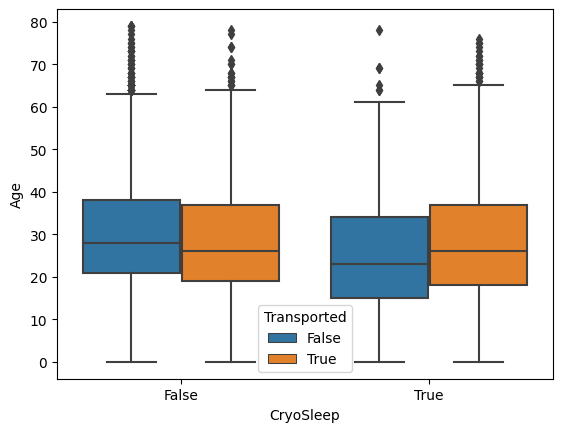

In [18]:
sns.boxplot(x='CryoSleep', y='Age', data=train_data, hue='Transported')

### CryoSleep

<AxesSubplot: xlabel='CryoSleep', ylabel='count'>

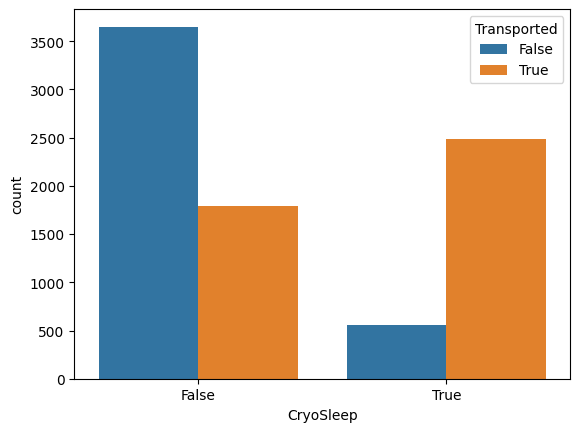

In [19]:
sns.countplot(data=train_data, x="CryoSleep", hue="Transported")

In [309]:
train_data.loc[((train_data['CryoSleep']==False) & (train_data['Transported']==False)),'CryoSleep']

0       False
2       False
3       False
13      False
15      False
        ...  
8674    False
8683    False
8686    False
8688    False
8691    False
Name: CryoSleep, Length: 3650, dtype: object

## Data Imputing

In [225]:
def impute_data(df):
    #Most of people from Earth are the most tranported
    df['HomePlanet']=df['HomePlanet'].fillna(value='Earth')
    # TRAPPIST-1e is the most frequency destination of the passenger will be debarking to
    df['Destination']=df['Destination'].fillna(value='TRAPPIST-1e')
    #Most of the passenger are non-VIP
    df['VIP']=df['VIP'].fillna(value=False)
    #CryoSleep
    df['CryoSleep']=df['CryoSleep'].fillna(value=False)
    # imputing Age group by VIP
    VIP = (df['VIP']==True)
    NonVIP = (df['VIP']==False)
    df.loc[VIP,'Age'] = df.loc[VIP,'Age'].fillna(df.loc[VIP,'Age'].median())
    df.loc[NonVIP,'Age'] = df.loc[NonVIP,'Age'].fillna(df.loc[NonVIP,'Age'].median())
    #imputing Cabin by previous value
    # df['Cabin'] = df['Cabin'].fillna(method='ffill')
    # Using KNN Imputer to deal with missing value of numerical variables
    numeric_col = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    imputer = KNNImputer(n_neighbors=7)
    imputer.fit(df[numeric_col])
    df[numeric_col] = imputer.transform(df[numeric_col])

    return df

In [226]:
train_data = impute_data(train_data)

<AxesSubplot: >

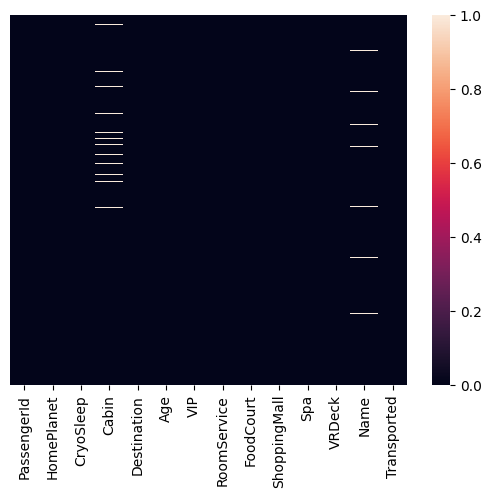

In [53]:
sns.heatmap(train_data.isnull(), yticklabels=False)

In [54]:
# total number of rows with missing value
train_data.shape[0] - train_data.dropna().shape[0]

397

In [227]:
# Removing the rest of rows that containing missing value
train_data = train_data.dropna(axis='index')
train_data.isnull().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [137]:
def split_column(df):

    # Create a column "PassengerGroup" from "PassengerId" 
    df['PassengerGroup'] = df['PassengerId'].str.split('_').str[0]

    # Create column "LastName" from "Name"
    # df['LastName'] = df['Name'].str.split(' ').str[1]

    # Split column "Cabin" into 3 columns "CabinDeck", "CabinNum", "CabinSide"
    df[['CabinDeck', 'CabinNum', 'CabinSide']] = df.Cabin.str.split('/', expand = True)

    # Drop 3 columns "PassengerId", "Name" and "Cabin"
    df = df.drop(['PassengerId', 'Name', 'Cabin'], axis='columns')

    return df

In [228]:
train_data = split_column(train_data)

In [139]:
def bool_to_int(df):
    df['CryoSleep'] = list(map(int, df['CryoSleep']))
    df['VIP'] = list(map(int, df['VIP']))
    return df

In [229]:
train_data['Transported'] = list(map(int, train_data['Transported']))
train_data = bool_to_int(train_data)

In [141]:
def dummy_variable(df):

    # Create dummy variables and drop original ones

    HomePlanetDummies = pd.get_dummies(df['HomePlanet'], prefix='HomePlanet')
    df = pd.concat([df, HomePlanetDummies], axis='columns')

    DestinationDummies = pd.get_dummies(df['Destination'], prefix='Destination')
    df = pd.concat([df, DestinationDummies], axis='columns')

    CabinDeckDummies = pd.get_dummies(df['CabinDeck'], prefix='CabinDeck')
    df = pd.concat([df, CabinDeckDummies], axis='columns')

    CabinSideDummies = pd.get_dummies(df['CabinSide'], prefix='CabinSide')
    df = pd.concat([df, CabinSideDummies], axis='columns')

    df = df.drop(['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], axis='columns')

    return df

In [230]:
train_data = dummy_variable(train_data)

In [145]:
train_data['TotalExpense']

0           0.0
1         736.0
2       10383.0
3        5176.0
4        1091.0
         ...   
8688     8536.0
8689        0.0
8690     1873.0
8691     4637.0
8692     4826.0
Name: TotalExpense, Length: 8296, dtype: float64

In [231]:
train_data['TotalExpense']= (train_data['RoomService'] + train_data['Spa'] + train_data['VRDeck'] + train_data['FoodCourt']+train_data['ShoppingMall'])


In [155]:
def planet2destination(data):
    df = data.copy()
    Planets = [('HomePlanet_Earth','Earth'),('HomePlanet_Europa','Europa'),('HomePlanet_Mars','Mars')]
    Destinations = [('Destination_55 Cancri e', 'Cancri'),('Destination_PSO J318.5-22','PSOJ318'),('Destination_TRAPPIST-1e','TRAPPIST-1e')]
    for Planet, pname in Planets:
        for Destination, dname in Destinations:
            df[f'{pname}_to_{dname}'] = df[Planet] * df[Destination]
    return df
    

In [153]:
 
test = train_data['HomePlanet_Earth'] * train_data['Destination_TRAPPIST-1e']
test

0       0
1       1
2       0
3       0
4       1
       ..
8688    0
8689    0
8690    1
8691    0
8692    0
Length: 8296, dtype: uint8

In [156]:
train_data = planet2destination(train_data)

In [158]:
pd.set_option('display.max_columns', None)
train_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,CabinNum,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,TotalExpense,Earth_to_Cancri,Earth_to_PSOJ318,Earth_to_TRAPPIST-1e,Europa_to_Cancri,Europa_to_PSOJ318,Europa_to_TRAPPIST-1e,Mars_to_Cancri,Mars_to_PSOJ318,Mars_to_TRAPPIST-1e
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,0,0001,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0.0,0,0,0,0,0,1,0,0,0
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,1,0002,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,736.0,0,0,1,0,0,0,0,0,0
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0003,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,10383.0,0,0,0,0,0,1,0,0,0
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0003,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,5176.0,0,0,0,0,0,1,0,0,0
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,1,0004,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1091.0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,0,9276,98,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,8536.0,0,0,0,1,0,0,0,0,0
8689,1,18.0,0,0.0,0.0,0.0,0.0,0.0,0,9278,1499,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0.0,0,1,0,0,0,0,0,0,0
8690,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,1,9279,1500,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1873.0,0,0,1,0,0,0,0,0,0
8691,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,0,9280,608,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,4637.0,0,0,0,1,0,0,0,0,0


# Data training

In [232]:
labels_training = train_data['Transported']
X_train, X_valid, y_train, y_valid = train_test_split(train_data, labels_training, test_size=0.4, random_state=42)

In [233]:
X_train = X_train.drop(['Transported'],axis=1)
X_valid = X_valid.drop(['Transported'],axis=1)

In [234]:
# create scaler
scaler = StandardScaler()
# apply normalization to training set and transform training set
X_train_scaled = scaler.fit_transform(X_train, y_train)
# transform validation set
X_valid_scaled = scaler.transform(X_valid)

In [23]:
from lazypredict.Supervised import LazyClassifier

In [24]:
clf = LazyClassifier(verbose = 0,
                     ignore_warnings = True,
                     custom_metric = None,
                     predictions = False,
                     random_state = 12,
                     classifiers = 'all')

models, predictions = clf.fit(X_train, X_valid ,y_train , y_valid)

100%|██████████| 29/29 [00:49<00:00,  1.72s/it]


In [235]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled,y_train)
predictions = svm_clf.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of SVC is: ',accuracy)
print('Cross Validation Score of SVC is : ' ,cross_val_score(svm_clf, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of SVC is:  0.8023501054534499
Cross Validation Score of SVC is :  0.7915022079267295


In [236]:
cross_val_score(svm_clf, X_valid_scaled, y_valid, cv=10)

array([0.80421687, 0.79216867, 0.77409639, 0.80421687, 0.77710843,
       0.78313253, 0.78313253, 0.82228916, 0.78012048, 0.82175227])

In [237]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled,y_train)
predictions = knn_classifier.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of KNN is: ',accuracy)
print('Cross Validation Score of KNN is : ' ,cross_val_score(knn_classifier, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of KNN is:  0.7683037059355228
Cross Validation Score of KNN is :  0.7622767086445329


In [238]:
decision_clf = DecisionTreeClassifier()
decision_clf.fit(X_train_scaled,y_train)
predictions = decision_clf.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of decision_clf is: ',accuracy)
print('Cross Validation Score of decision_clf is : ' ,cross_val_score(decision_clf, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of decision_clf is:  0.7417896956914733
Cross Validation Score of decision_clf is :  0.7559495902160679


In [239]:
GB_clf = GradientBoostingClassifier()
GB_clf.fit(X_train,y_train)
predictions = GB_clf.predict(X_valid)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of decision_clf is: ',accuracy)
print('Cross Validation Score of decision_clf is : ' ,cross_val_score(GB_clf, X_valid, y_valid, cv=5).mean())

Accuracy of decision_clf is:  0.8107863814401929
Cross Validation Score of decision_clf is :  0.8011489396500027


In [240]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_scaled,y_train)
predictions = forest_clf.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of decision_clf is: ',accuracy)
print('Cross Validation Score of decision_clf is : ' ,cross_val_score(forest_clf, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of decision_clf is:  0.7975293763181681
Cross Validation Score of decision_clf is :  0.7933117083719493


In [31]:
from xgboost import XGBClassifier

In [241]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled,y_train)
predictions = forest_clf.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of decision_clf is: ',accuracy)
print('Cross Validation Score of decision_clf is : ' ,cross_val_score(forest_clf, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of decision_clf is:  0.7975293763181681
Cross Validation Score of decision_clf is :  0.791504933762198


In [198]:
import lightgbm as lgb

In [242]:
#lgbm = lgb.LGBMClassifier(boosting_type ='gbdt', learning_rate = 0.005, n_estimators = 500, num_leaves = 31)
lgbm = lgb.LGBMClassifier(random_state = 5)
lgbm.fit(X_train_scaled, y_train)
predictions = lgbm.predict(X_valid_scaled)
accuracy = metrics.accuracy_score(y_valid, predictions)
print('Accuracy of decision_clf is: ',accuracy)
print('Cross Validation Score of decision_clf is : ' ,cross_val_score(forest_clf, X_valid_scaled, y_valid, cv=5).mean())

Accuracy of decision_clf is:  0.8113889725821031
Cross Validation Score of decision_clf is :  0.7957231641498119


In [36]:
 #Compare all classifier
# --------------------
#Fit models
#knn
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train_scaled,y_train)
#decision tree
decision_clf = DecisionTreeClassifier()
decision_clf.fit(X_train_scaled,y_train)
#random forest
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_scaled,y_train)
#XGB
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_scaled,y_train)
#Tree
xrf_clf = ExtraTreesClassifier()
xrf_clf.fit(X_train_scaled,y_train)
#SVM
svm_clf = SVC()
svm_clf.fit(X_train_scaled,y_train)
#naive bayes
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train_scaled,y_train)
#NN
nn_clf = MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000)
nn_clf.fit(X_train_scaled,y_train)
#LGBM
lgbm_clf = lgb.LGBMClassifier(random_state = 5)
lgbm_clf.fit(X_train_scaled, y_train)

LGBMClassifier(random_state=5)

In [114]:
modelss= list([('knn_classifier', 'knn_classifier'),('decision tree', 'decision tree')])
for i, model in modelss:
    print('Accuracy of ', i , 'is: ',model)

Accuracy of  knn_classifier is:  knn_classifier
Accuracy of  decision tree is:  decision tree


In [37]:
#Error of each model, here we use mean absolute error
models= [('knn_classifier', knn_classifier),('decision tree', decision_clf),('random forest', forest_clf), ('XGB', xgb_clf),('ExtraTree',xrf_clf),('SVM', svm_clf),('Naive Bayes', gaussian_clf),('Neural Network',nn_clf),('LGBM',lgbm_clf)]
for i, model in models:
    predictions = model.predict(X_valid_scaled)
    accuracy = metrics.accuracy_score(y_valid, predictions)
    print('Accuracy of ', i , 'is: ',accuracy)
    print('Cross Validation Score of ', i , 'is : ' ,cross_val_score(model,X_valid_scaled, y_valid, cv=5).mean())

Accuracy of  knn_classifier is:  0.7704819277108433
Cross Validation Score of  knn_classifier is :  0.7265060240963856
Accuracy of  decision tree is:  0.7457831325301205
Cross Validation Score of  decision tree is :  0.7186746987951806
Accuracy of  random forest is:  0.8066265060240964
Cross Validation Score of  random forest is :  0.7753012048192771
Accuracy of  XGB is:  0.805421686746988
Cross Validation Score of  XGB is :  0.7927710843373494
Accuracy of  ExtraTree is:  0.7987951807228916
Cross Validation Score of  ExtraTree is :  0.7674698795180722
Accuracy of  SVM is:  0.8036144578313253
Cross Validation Score of  SVM is :  0.7626506024096386
Accuracy of  Naive Bayes is:  0.7289156626506024
Cross Validation Score of  Naive Bayes is :  0.6198795180722891
Accuracy of  Neural Network is:  0.7873493975903615
Cross Validation Score of  Neural Network is :  0.7644578313253012
Accuracy of  LGBM is:  0.8132530120481928
Cross Validation Score of  LGBM is :  0.7963855421686746


# Testing Data

In [253]:
X_test_data = pd.read_csv('test.csv')
# For writing to submission file
PassengerIdTest = X_test_data['PassengerId']

In [254]:
X_test_data = impute_data(X_test_data)

In [384]:
# X_test_data = X_test_data.dropna(axis='index')

In [255]:
X_test_data = split_column(X_test_data)

In [256]:
X_test_data = bool_to_int(X_test_data)

In [257]:
X_test_data = dummy_variable(X_test_data)

In [258]:
X_test_data['CabinNum'] = X_test_data['CabinNum'].fillna(method='ffill')

In [259]:
X_test_data['TotalExpense']= X_test_data['RoomService'] + X_test_data['Spa'] + X_test_data['VRDeck'] + X_test_data['FoodCourt']+X_test_data['ShoppingMall']

In [187]:
X_test_data = planet2destination(X_test_data)

In [260]:
X_test_data

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,CabinNum,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_P,CabinSide_S,TotalExpense
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,0013,3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,0018,4,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,2832.0
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0019,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0.0
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,0021,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,7418.0
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,0023,5,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,645.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,1,34.0,0,0.0,0.0,0.0,0.0,0.0,9266,1496,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0.0
4273,0,42.0,0,0.0,847.0,17.0,10.0,144.0,9269,1496,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1018.0
4274,1,26.0,0,0.0,0.0,0.0,0.0,0.0,9271,296,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0.0
4275,0,26.0,0,0.0,2680.0,0.0,0.0,523.0,9273,297,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,3203.0


In [264]:

X_test_data = scaler.transform(X_test_data)

In [262]:
X_train_data = train_data.drop(['Transported'], axis=1)
Y_train_data = train_data['Transported']

In [263]:
scaler = StandardScaler()
X_train_data=scaler.fit_transform(X_train_data, Y_train_data)

In [92]:
forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_data,Y_train_data)
prediction = forest_clf.predict(X_test_data)

In [194]:
GB_clf = GradientBoostingClassifier()
GB_clf.fit(X_train_data,Y_train_data)
prediction = GB_clf.predict(X_test_data)

In [265]:
#lgbm = lgb.LGBMClassifier(boosting_type ='gbdt', learning_rate = 0.005, n_estimators = 500, num_leaves = 31)
lgbm = lgb.LGBMClassifier(random_state = 5)
lgbm.fit(X_train_data, Y_train_data)
prediction = lgbm.predict(X_test_data)

In [266]:
res = pd.DataFrame(
        {
            'PassengerId': list(PassengerIdTest),
            'Transported': [(p == 1) for p in list(prediction)]
        }
    )
res.to_csv('submission.csv', index=False)